<center><h3><b>Basic of Langgraph in Local system</b></h3>
<br><br>
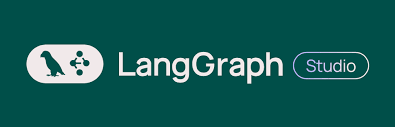<img> </center>

*install the dependencies*

In [24]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

**MISTRAL API Keys**
<br>
'How to get mine?' -><a href="https://console.mistral.ai/api-keys">Get My Mistral API Key</a>

In [25]:
key="tVKig5OytBqAtxcjOh9n0gz0RlJ5hEn9"
import os

In [26]:
from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage,HumanMessage

os.environ["MISTRAL_API_KEY"]="tVKig5OytBqAtxcjOh9n0gz0RlJ5hEn9"


In [27]:
llm=ChatMistralAI(
    model="mistral-small-latest",
    temperature=0,
    max_retries=10
)

In [28]:
#prompts
sys_prompt="You are a helpful assistant that translates English to Japanese and also in french"
hum_prompt="Translate the user sentence without giving more details, just the translation: I love programming."


In [29]:
response=llm.invoke([
    SystemMessage(content=sys_prompt),
    HumanMessage(content=hum_prompt)
]).content.strip()

In [30]:
print(response)

Japanese: プログラミングが大好きです。

French: J'adore la programmation.


In [31]:
from typing import Dict,TypedDict

class State(TypedDict):
    messages: Dict

In [32]:
def read_file(file_path):
    with open(file_path,'r') as f:
        return f.read()

In [33]:
from langchain_core.messages import SystemMessage,ToolMessage,AIMessage,HumanMessage
from langgraph.graph import StateGraph,START,END
import uuid

In [34]:
cv_path="cv.txt"
job_path="job_descrip.txt"
start_state={"messages":{"cv_path":cv_path,"job_path":job_path}}

In [35]:
# Read CV
def get_cv_content(state: dict): # The state here is -> {"messages": {"cv_path": cv_path, "job_path": job_path}}
    print("***** get_cv_content *****")
  
    # Extract the CV file path from the state
    cv_path = state['messages']['cv_path']
    cv_content = read_file(cv_path)
    
    # Create a ToolMessage object with the CV content and a unique tool call ID
    tool_call = ToolMessage(
        content=cv_content,
        tool_call_id=str(uuid.uuid4())
    )

    # Update the state with the CV content and retain the job file path
    new_state = {
        "messages": {
            "job_path": state['messages']['job_path'],
            "cv_content": tool_call
        }
    }
    return new_state

# Read Job Offer
def get_job_description(state: dict): # The state here will be the get_cv_content result -> {"messages": {"job_path": job_path, "cv_content": ___}}
    print("***** get_job_description *****")

    # Extract the job description file path from the state
    job_path = state['messages']['job_path']
    
    # Read the content of the job description file
    job_content = read_file(job_path)

    # Create a ToolMessage object with the job description content and a unique tool call ID
    tool_call = ToolMessage(
        content=job_content,
        tool_call_id=str(uuid.uuid4())
    )

    # Update the state with the job description content and retain the CV content
    new_state = {
        "messages": {
            "cv_content": state['messages']['cv_content'],
            "job_content": tool_call
        }
    }
    return new_state

In [36]:
# Evaluate Match
def evaluate_match(state: dict): # The state here will be the get_job_description result -> {"messages": {"cv_content": ___, "job_content": ___}}
    print("***** evaluate_match *****")

    # Extract the CV and job description content from the state
    cv_content = state["messages"]["cv_content"].content
    job_content = state["messages"]["job_content"].content

    # Create the evaluation prompts
    hum_evaluation_template = """CV:
    {cv}
    ===
    Job Description:
    {job}
    ===
    Evaluate whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific reasons for your assessment, ensuring a detailed and professional response:
    """
    hum_evaluation_prompt = hum_evaluation_template.format(cv=cv_content, job=job_content)
    sys_evaluation_prompt = """You are tasked with evaluating whether the CV aligns with the job description provided. Clearly indicate the degree of match and provide specific, detailed reasons for your assessment."""

    # Invoke the LLM with the evaluation prompts
    response = llm.invoke([SystemMessage(content=sys_evaluation_prompt),
                           HumanMessage(content=hum_evaluation_prompt)])
    content = response.content.strip()

    # Create an AIMessage object with the evaluation response and a unique AI call ID
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    # Update the state with the evaluation response
    new_state = {
        "messages": {
            "evaluation": ai_call
        }
    }
    return new_state

In [37]:
# Generate Email
def generate_email(state: dict): # The state here will be the evaluate_match result -> {"messages": {"evaluation": ___}}
    print("***** generate_email *****")

    # Extract the evaluation result from the state
    evaluation_result = state["messages"]["evaluation"].content

    # Create the email prompts
    hum_email_template = """Job Application Evaluation:
    {evaluation}
    ===
    Based on the evaluation of the match between the candidate's CV and the job description, draft an email to the candidate communicating the result of the assessment. Clearly indicate whether or not the candidate has been selected for the position and provide the reasons for the decision. Ensure the tone is polite, professional, and respectful, starting the email with a courteous acknowledgment.
    Email:
    """
    hum_email_prompt = hum_email_template.format(evaluation=evaluation_result)
    sys_email_prompt = """You are a hiring manager tasked with drafting an email to a candidate regarding the result of their job application assessment. Clearly communicate whether the candidate has been selected for the position, and provide reasons for the decision. Maintain a polite, professional, and respectful tone, starting the email with a courteous acknowledgment."""

    # Invoke the LLM with the email prompts
    response = llm.invoke([SystemMessage(content=sys_email_prompt),
                           HumanMessage(content=hum_email_prompt)])
    content = response.content.strip()

    # Create an AIMessage object with the email content and a unique AI call ID
    ai_call = AIMessage(
        content=content,
        ai_call_id=str(uuid.uuid4())
    )

    # Update the state with the email content
    new_state = {
        "messages": {
            "email": ai_call
        }
    }

    return new_state

*Start the Graph with the initial state*

In [ ]:

workflow = StateGraph(State)

# We add the nodes that corresponds to the functions we defined. We have to give them a name
workflow.add_node("read_cv", get_cv_content)
workflow.add_node("get_job_description", get_job_description)
workflow.add_node("evaluate_match", evaluate_match)
workflow.add_node("generate_email", generate_email)

# We add the edges that connect the nodes.
## We start from the START and indicate the next node, that in this case is "read_cv"
workflow.add_edge(START, "read_cv")
workflow.add_edge("read_cv", "get_job_description")
workflow.add_edge("get_job_description", "evaluate_match")
workflow.add_edge("evaluate_match", "generate_email")
workflow.add_edge("generate_email", END)

# We compile the graph
graph = workflow.compile()


**OUTPUT Generation**
<br>
`graphs and state`

In [39]:
# Iterate over the graph
for output in graph.stream(start_state):
    print("Current Output:", output)

print("\n***** Process completed successfully!! *****\n")
print(output['generate_email']['messages']['email'].content)

***** get_cv_content *****
Current Output: {'read_cv': {'messages': {'job_path': 'job_descrip.txt', 'cv_content': ToolMessage(content='Kunal Kumar Mishra\nSonia Vihar, Delhi, 110094\nEmail: Kunalmishravats@gmail.com | Phone: +91-8743052389\nGitHub LinkedIn\nEducation\nâ€¢ Bhagwan Parshuram Institute of Technology, Delhi\nB. Tech in Computer Science and Engineering, Percentage: 84% September 2021 - June 2024 â€¢ Ambedkar Institute of Technology, Board of Technical Education, Delhi\nDiploma in ITES&M, Percentage: 75% August 2018 â€“ July 2021\nExperience\nAI/ML Engineer, MTSL, Noida July 2024 - Presentâ€¢ Streamlined And Automated The Signature Extraction Process By Utilizing AWS Sagemaker, AWS\nLambda, And AWS ECR In The Design And Implementation Of The SMC Signature Extraction\nSolution. â€¢ I created and refined the Almonds Data Engineering project using AWS Glue, Athena, and\nRedshift in order to create robust data pipelines, increase the efficiency of data processing, and\nenable pe

*Resources*
<br>
<h5>Langchain -><a href="https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot">LangGraph<a></h5>
<br>
<a href="https://medium.com/@daniel.puenteviejo/langgraph-mistral-cv-evaluator-agent-system-b74ee5390500">CV AI AGENT Using Mistral<a>

**THANK YOU**